# Spin dynamics

## imports

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *

## System described here

We want to describe our system as it will be at first on the benchtop version.
We have the laser and the rf field $B_1$ along the z axis, the field to measure $B_0$ in the  yz-plane (according to [1]).

$$ \partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} = \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} \wedge \begin{pmatrix} 0 \\ \gamma B_0 \sin(\theta) \\ \gamma B_0 \cos(\theta) + \gamma B_{rf}\cos(\omega_{rf} t) \end{pmatrix} - \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} + R_{op} \begin{pmatrix}- S_x \\ - S_y \\ S_0-M_z\end{pmatrix} $$


$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\left(\gamma B_0 \cos(\theta) +\gamma B_{rf} \cos(\omega_{rf} t) \right) S_y - \gamma B_0\sin(\theta) S_z  \\ 
- \left( \gamma B_0 \cos(\theta) + \gamma B_{rf} \cos(\omega_{rf} t) \right) S_x  \\ 
\gamma B_0 \sin(\theta) S_x 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$




With :
- $\hat{S}$ : the spin operator
- $B_0$ : the bias field, i.e. the field we want to measure, assumed here as DC
- $B_{rf}$ : the intensity of the RF field to pump the spins
- $\gamma$ : the gyromagnetic ratio of $^{87}R_b$
- $\theta$ : the angle between the bias field $\vec{B_0}$ and the basis
- $\Gamma$ : the relaxation rate (assumed as equal to $\Gamma_{SE} + \Gamma_{SD} + \Gamma_{wall}$)
- $R_{op}$ : the optical pumping rate; $R_{op} = \sigma_{abs} \phi_{opt}$

In [6]:
"""## Constants
gamma = 7e9     # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
Gamma_natural = 36.10e6 #Hz

## Parameters
Gamma = 50000    # Relaxation rate (Hz) ; estimated from the google colab 'Vapour cell simulation'
B_0 = 100e-6    # Static field intensity (Tesla)
B_1 = 1e-3      # RF field intensity (Tesla)
theta = 90*np.pi/180

#P_laser = np.logspace(np.log10(4e-6), np.log10(0.2e-3), num=6) # Laser power (W)
beam_diameter = 1e-3 # self-explanatory (m)

P_laser = 2e-6

P = 3e4        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-2 # Cell length (m)
T = 273.15+60   # Cell temperature (K)

I_sat = 44.84

## Derived parameters
omega = gamma * B_0    # Frequency of the RF field (Hz)

I = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
R_op = Gamma_natural * (I)/(I+I_sat)

n_ideal_gas = P/(k*T)     # Rb density (m^-3)
n = 1/T*10**(21.866+4.312-4040/T)
N = P*V/(k*T) # Number of particles
S_0 = 1      # maximum magnetization""""Quantum Bloch Equation.ipynb"
## Constants
gamma = 7e9     # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
Gamma_natural = 36.10e6 #Hz

## Parameters
Gamma = 50e3    # Relaxation rate (Hz) ; estimated from the google colab 'Vapour cell simulation'
B_0 = 100e-6    # Static field intensity (Tesla)
B_1 = 1e-3      # RF field intensity (Tesla)
theta = 90*np.pi/180

#P_laser = np.logspace(np.log10(4e-6), np.log10(0.2e-3), num=6) # Laser power (W)
beam_diameter = 1e-3 # self-explanatory (m)

P_laser = 2e-6

P = 3e4        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-2 # Cell length (m)
T = 273.15+60   # Cell temperature (K)

I_sat = 44.84

## Derived parameters
omega = gamma * B_0    # Frequency of the RF field (Hz)

I = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
R_op = Gamma_natural * (I)/(I+I_sat)

Gamma_tot = Gamma + R_op

Delta = omega - gamma*B_0
delta = 1/(2*np.sqrt(2)) * gamma * B_1 * np.sin(theta)

n_ideal_gas = P/(k*T)     # Rb density (m^-3)
n = 1/T*10**(21.866+4.312-4040/T)
N = P*V/(k*T) # Number of particles
M_0 = 1      # maximum magnetization
S_0 = 1 

$$
\partial_t \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix} =
\begin{pmatrix} 
\left(\gamma B_0 \cos(\theta) +\gamma B_{rf} \cos(\omega_{rf} t) \right) S_y - \gamma B_0\sin(\theta) S_z  \\ 
- \left( \gamma B_0 \cos(\theta) \gamma B_{rf} \cos(\omega_{rf} t) \right) S_x  \\ 
\gamma B_0 \sin(\theta) S_x 
\end{pmatrix}
- \Gamma \begin{pmatrix} S_x \\ S_y \\ S_z \end{pmatrix}
+ R_{op} \begin{pmatrix} - S_x \\ - S_y \\ S_0 - S_z \end{pmatrix}.
$$

In [7]:
def bloch_equations(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    term1 = B_1 * cos_omega_t + B_0 * np.cos(theta)
    term2 = B_0 * np.sin(theta)

    dSxdt = gamma * term1 * Sy - gamma * term2 * Sz - (Gamma + R_op) * Sx
    dSydt =  - gamma * term1 * Sx - (Gamma + R_op) * Sy
    dSzdt = gamma * term2 * Sx - (Gamma) * Sz + R_op * (S_0 - Sz)
    return [dSxdt, dSydt, dSzdt]

"""def bloch_equations_chinese_paper(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0, theta):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    
    # Effective magnetic field components
    Bx_eff = 0
    By_eff = gamma * B_1 * np.sin(theta) * cos_omega_t
    Bz_eff = gamma * B_0 + gamma * B_1 * np.cos(theta) * cos_omega_t

    # Bloch equations with pumping and relaxation
    dSxdt = Sy * Bz_eff - Sz * By_eff - Gamma * Sx - R_op * Sx
    dSydt = Sz * Bx_eff - Sx * Bz_eff - Gamma * Sy - R_op * Sy
    dSzdt = Sx * By_eff - Sy * Bx_eff - Gamma * Sz + R_op * (S_0 - Sz)

    return [dSxdt, dSydt, dSzdt]"""

def bloch_equations_chinese_paper(t, S, gamma, B_0, B_1, omega, Gamma, R_op, S_0, theta):
    Sx, Sy, Sz = S
    cos_omega_t = np.cos(omega * t)
    
    # Magnetic field vector components (B0 along z, B1 in yz-plane)
    Bx_eff = 0
    By_eff = gamma * B_1 * np.sin(theta) * cos_omega_t
    Bz_eff = gamma * B_0 + gamma * B_1 * np.cos(theta) * cos_omega_t

    # Magnetic torque (precession)
    dSxdt = Sy * Bz_eff - Sz * By_eff
    dSydt = Sz * Bx_eff - Sx * Bz_eff
    dSzdt = Sx * By_eff - Sy * Bx_eff

    # Relaxation
    dSxdt += -Gamma * Sx
    dSydt += -Gamma * Sy
    dSzdt += -Gamma * Sz

    # Optical pumping toward the laser direction (sinθ ȷ̂ + cosθ ẑ)
    S_target_y = S_0 * np.sin(theta)
    S_target_z = S_0 * np.cos(theta)

    dSxdt += -R_op * Sx          # No pumping along x (laser has no x-component)
    dSydt += R_op * (S_target_y - Sy)
    dSzdt += R_op * (S_target_z - Sz)

    return [dSxdt, dSydt, dSzdt]

def solve_bloch_equations(initial_state, t_span, t_eval, gamma, B_0, B_1, omega, Gamma, R_op, S_0, theta):
    solution = solve_ivp(
        bloch_equations_chinese_paper,
        t_span,
        initial_state,
        method='BDF',  
        t_eval=t_eval,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, S_0, theta)
    )
    return solution

In [8]:
initial_state = [0, 0, 0]
t_span = [0, 1000/(gamma*B_0)]
sampling_rate = int(3*gamma*B_0) #adjust to have a frequency that allows me to detect the oscillation
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0, theta=theta)

t = solution.t
Sx, Sy, Sz = solution.y

print(f"Final Sx: {Sx[-1]:.4f}")
print(f"Final Sy: {Sy[-1]:.4f}")
print(f"Final Sz: {Sz[-1]:.4f}")

Final Sx: 0.0671
Final Sy: 0.9589
Final Sz: 0.1146


C:\Users\ma1196605\AppData\Local\Temp\ipykernel_19436\3479991744.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\ma1196605\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


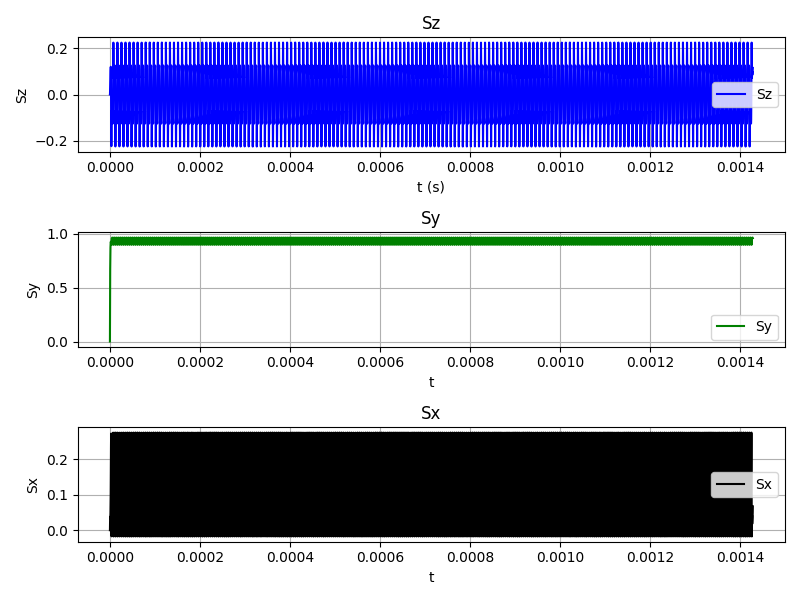

In [9]:
%matplotlib widget
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

points_to_skip = 0

axes[0].plot(t[points_to_skip:], Sz[points_to_skip:], color='blue', label='Sz')
axes[0].set_title('Sz')
axes[0].set_xlabel('t (s)')
axes[0].set_ylabel('Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t[points_to_skip:], Sy[points_to_skip:], color='green', label='Sy')
axes[1].set_title('Sy')
axes[1].set_xlabel('t')
axes[1].set_ylabel('Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t[points_to_skip:],Sx[points_to_skip:], color='black', label='Sx')
axes[2].set_title('Sx')
axes[2].set_xlabel('t')
axes[2].set_ylabel('Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

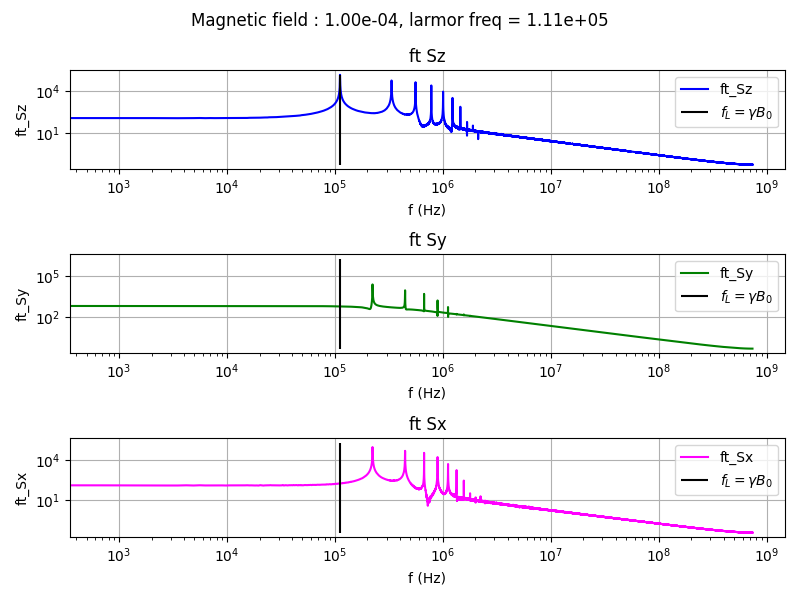

In [10]:
dt = t_eval[1]-t_eval[0]
freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
#freq_shifted = np.abs(np.fft.fftshift(freq))

ft_Sz = np.abs(np.fft.rfft(Sz[points_to_skip:]))
ft_Sy = np.abs(np.fft.rfft(Sy[points_to_skip:]))
ft_Sx = np.abs(np.fft.rfft(Sx[points_to_skip:]))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

fig.suptitle('Magnetic field : {:.2e}, larmor freq = {:.2e}'.format(B_0, gamma*B_0/(2*np.pi)))

axes[0].plot(freq, ft_Sz, color='blue', label='ft_Sz')
axes[0].vlines(gamma*B_0/(2*np.pi), min(ft_Sz), max(ft_Sz), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('ft Sz')
axes[0].set_xlabel('f (Hz)')
axes[0].set_ylabel('ft_Sz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(freq, ft_Sy, color='green', label='ft_Sy')
axes[1].vlines(gamma*B_0/(2*np.pi), min(ft_Sy), max(ft_Sy), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('ft Sy')
axes[1].set_xlabel('f (Hz)')
axes[1].set_ylabel('ft_Sy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(freq, ft_Sx, color='magenta', label='ft_Sx')
axes[2].vlines(gamma*B_0/(2*np.pi), min(ft_Sx), max(ft_Sx), color = 'k', label='$f_{L} = \gamma B_0 $')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title('ft Sx')
axes[2].set_xlabel('f (Hz)')
axes[2].set_ylabel('ft_Sx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Magnetization as function of the magnetic field

We try here to reproduce the figure 4 from [5]. For this, we vary the value of the magnetic field and observe the behavior of Mx and My.

In [11]:
## steady state bloch equation solver
from scipy.optimize import fsolve

def steady_state_bloch_equations(M, gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta):
    Mx, My, Mz = M
    # For steady state, choose t = 0 so that cos(omega*t) = 1.
    cos_omega_t = np.cos(omega * 0)  # = 1
    term1 = B_1 * cos_omega_t + B_0 * np.cos(theta)
    term2 = B_0 * np.sin(theta)
    
    # Set the time derivatives to zero (steady state)
    eq1 = gamma * term1 * My - gamma * term2 * Mz - (Gamma + R_op) * Mx
    eq2 = - gamma * term1 * Mx - (Gamma + R_op) * My
    eq3 = gamma * term2 * Mx - Gamma * Mz + R_op * (M_0 - Mz)
    
    return [eq1, eq2, eq3]

def solve_steady_state_bloch(initial_state, gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta):
    sol, info, ier, mesg = fsolve(
        steady_state_bloch_equations,
        initial_state,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, M_0, theta),
        full_output=True
    )
    if ier != 1:
        print("Solution not found:", mesg)
    return sol

In [12]:
Gamma_test = 50

B_w = Gamma_test/gamma
B_test = np.linspace(-400000*B_w,400000*B_w,1000)

initial_state = [0, 0, 0]

Mx_b, My_b, Mz_b = [],[],[]


for i,By in enumerate(B_test):
    sampling_rate = int(3*gamma*np.abs(By)) #adjust to have a frequency that allows me to detect the oscillation
    t_eval = np.linspace(t_span[0], t_span[1], sampling_rate) 
    solution = solve_steady_state_bloch(initial_state, gamma = gamma, B_0 = By, B_1 = B_1, omega = omega, Gamma = Gamma_test, R_op = 3e5, M_0 = 1, theta=np.pi/2)
    Mx_temp, My_temp, Mz_temp = solution
    Mx_b.append(Mx_temp)
    My_b.append(My_temp)
    Mz_b.append(Mz_temp)

Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
Solution not found: The iteration is not making good progress, as measured by the 
 improvement from the last ten iter

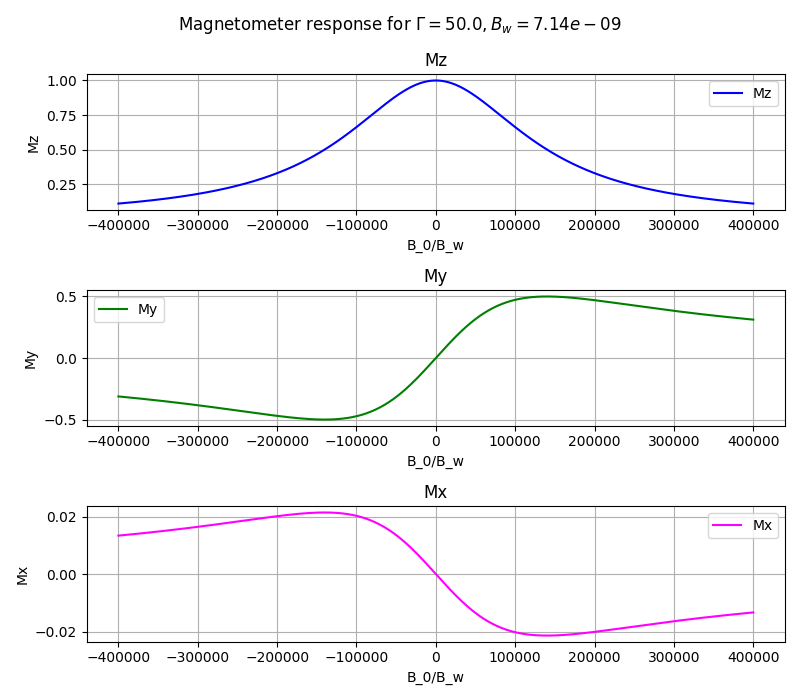

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))

fig.suptitle('Magnetometer response for $\Gamma = {0:.1f}, B_w = {1:.2e}$'.format(Gamma_test, B_w))

axes[0].plot(B_test/B_w, Mz_b, color='blue', label='Mz')
axes[0].set_title('Mz')
axes[0].set_xlabel('B_0/B_w')
axes[0].set_ylabel('Mz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(B_test/B_w, My_b, color='green', label='My')
axes[1].set_title('My') 
axes[1].set_xlabel('B_0/B_w')
axes[1].set_ylabel('My')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(B_test/B_w, Mx_b, color='magenta', label='Mx')
axes[2].set_title('Mx')
axes[2].set_xlabel('B_0/B_w')
axes[2].set_ylabel('Mx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Discussions

The factor 2 between the frequency observed in $M_z$ and the Larmor frequency probably comes from the product between the $\cos(\omega t)$ and $M_y$, the latter behaving like a sine wave. The product creates a frequency doubling. 

# Light absorption of the system

## Equations and system described

In [3] is given the differential equation for the light intensity across the vapour cell :

$$\partial_z I(z) = -n \sigma(\nu) I(z) (1-sM_z)$$
Where : 
- n is the density of alkali-metal atoms; $n = \frac{1}{T}10^{21.866+A - \frac{B}{T}}$
- $\sigma(\nu)$ is the photon absorption cross section
- s is the photon polarization
- $M_{\perp}$ is the magnetization on the axis normal to the bias field 

*OBSOLETE AND WRONG* <br>
Now we need to express $M_{\perp}$ by looking for the normal vectors to $\vec{B_0}$.
We find :
$$||\vec{M_{\perp}}|| = \sqrt{M_x^2 + \left( M_y \cos(\theta) - M_z \sin(\theta) \right)}$$

In [14]:
def absorption_equation(z, I_0, sigma, n, M):
    I = I_0 * np.exp(-n*sigma*(1-M)*z)
    return I

#Mperp = np.sqrt(Sx**2 + (Sy*np.cos(theta) - Sz*np.sin(theta))**2)/S_0 #n * mu_B * Sz

I_z_t = np.zeros(len(Sy))
test = np.zeros(len(Sy))

for i, Mz in enumerate(Sz):
    I_z_t[i] = absorption_equation(z = z_cell, I_0 = I, sigma = sigma, n=n, M= Mz)
    test[i] = -n*sigma*(Mz)*z_cell

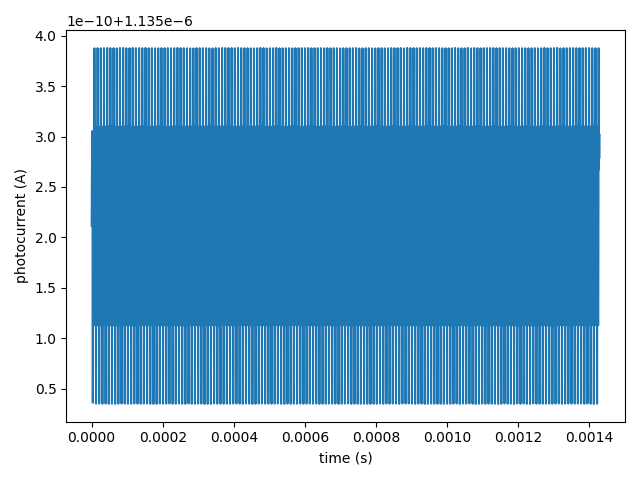

In [15]:
R = 0.568 #A/W, for standard thorlabs Si photodiode

P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
photocurrent_z_t = R*P_z_t

fig,axes=plt.subplots()
axes.plot(t,photocurrent_z_t)
axes.set_xlabel('time (s)')
axes.set_ylabel('photocurrent (A)')
plt.tight_layout()
plt.show()

In [16]:
initial_state = [0, 0, 0]
t_span = [0, 1000/(gamma*B_0)]
sampling_rate = int(3*gamma*B_0) #adjust to have a frequency that allows me to detect the oscillation
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, S_0=S_0, theta = theta)

t = solution.t
Sx, Sy, Sz = solution.y

print(f"Final Sx: {Sx[-1]:.4f}")
print(f"Final Sy: {Sy[-1]:.4f}")
print(f"Final Sz: {Sz[-1]:.4f}")

Final Sx: 0.0671
Final Sy: 0.9589
Final Sz: 0.1146


In [17]:
# Absorption coefficient
alpha_0 = n * sigma  # [1/m]
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
M_real = (np.cos(theta)*Sz + np.sin(theta)*Sy) * n * mu_eff
# Normalize magnetization
M0_real = np.max(M_real)  # Or n * mu_eff
P_t = M_real / M0_real

# Light intensity after cell (Beer-Lambert)
alpha_t = alpha_0 * (1 - P_t)  # More polarization → less absorption
I_out = I * np.exp(-alpha_t * z_cell)  # W/m²

# Total transmitted power (W)
A_beam = np.pi * (beam_diameter / 2)**2
P_out = I_out * A_beam  # W

# Photodiode current (A)
R = 0.568  # A/W
I_PD = R * P_out  # A

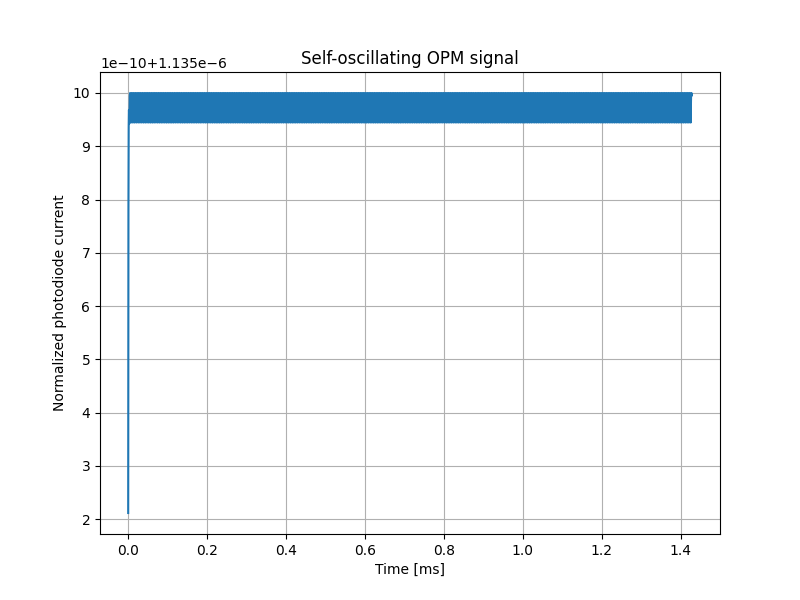

In [18]:
%matplotlib widget
plt.figure(figsize=(8,6))
plt.plot(t * 1e3, I_PD)  # normalized, time in ms
plt.xlabel("Time [ms]")
plt.ylabel("Normalized photodiode current")
plt.title("Self-oscillating OPM signal")
plt.grid()
plt.show()


0.22136750955275677


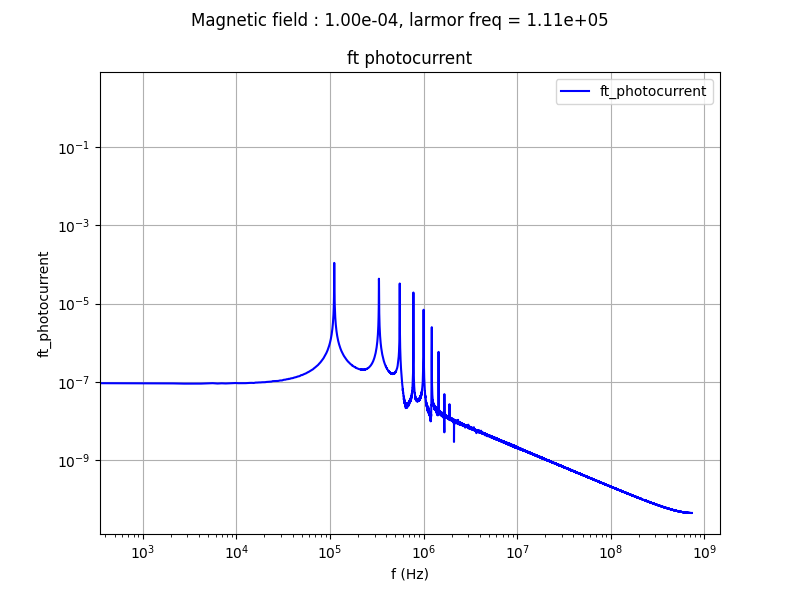

In [19]:
ft_photocurrent = np.abs(np.fft.rfft(photocurrent_z_t))

mask = (freq > (2*gamma*B_0/(2*np.pi) - 0.1*2*gamma*B_0/(2*np.pi))) & (freq < (2*gamma*B_0/(2*np.pi) + 0.1*2*gamma*B_0/(2*np.pi)))

subarray = ft_photocurrent[mask]

mask_lower = (freq > 2*gamma*B_0/(2*np.pi) - 0.5 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) - 0.1 * 2*gamma*B_0/(2*np.pi))

mask_upper = (freq > 2*gamma*B_0/(2*np.pi) + 0.1 * 2*gamma*B_0/(2*np.pi)) & (freq < 2*gamma*B_0/(2*np.pi) + 0.5 * 2*gamma*B_0/(2*np.pi))

mask2 = mask_lower | mask_upper

magnitude = np.max(subarray) - np.mean(ft_photocurrent[mask2])
SNR = np.max(subarray) / np.mean(ft_photocurrent[mask2])
print(SNR)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

fig.suptitle('Magnetic field : {:.2e}, larmor freq = {:.2e}'.format(B_0, gamma*B_0/(2*np.pi)))

axes.plot(freq, ft_photocurrent, color='blue', label='ft_photocurrent')
#axes.vlines(2*gamma*B_0/(2*np.pi), min(ft_photocurrent), max(ft_photocurrent), color = 'k', label='$2f_{L} = 2\gamma B_0 $')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_title('ft photocurrent')
axes.set_xlabel('f (Hz)')
axes.set_ylabel('ft_photocurrent')
axes.legend()
axes.grid(True)

plt.show()

In [20]:
np.mean(ft_photocurrent[mask2])

np.float64(9.82373701017645e-07)

Oscillates at $2 \omega_L$

# Sources



[1] : 'How to build a magnetometer with thermal atomic vapor: a tutorial', A. Fabricant, I. Novikova, G. Bison. <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[3] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023